In [1]:
import os
import re
import glob
import math
import numpy             as np
import matplotlib.pyplot as plt
from pandas              import DataFrame
from datetime            import datetime
from scipy.interpolate   import make_interp_spline
from scipy.optimize      import curve_fit

In [2]:
threshold = np.linspace(0.01, 60, 31)  #not used
slope = np.linspace(0.01, 10, 50)      #not used
gamma = np.linspace(0.01, 0.99, 100)   #used for prob o gamma
delta = 0.02                           #not used

In [3]:
#TSIDs:

TSIDs = ['TEST-HOP']   #enter TSIDs

#TSIDs = []
#for i in range (6,12,1): TSIDs.append('TS'+str(i).zfill(3))

In [4]:
#Data File Path:

file_path = os.path.join(glob.glob('C:\\Users\\mvomstein\\projects\\vt-2pod-master')[0], 'DATA')

In [5]:
#Show containing TSIDs:

#for i in os.listdir(file_path): print(i)

In [6]:
#Allocate Data in Variables:

for TSID in TSIDs:
    fpTS = os.path.join(file_path, TSID)

    for file in os.listdir(fpTS):
        if os.path.splitext(file)[1] == '.npy':
            x = re.split("_", file)
            if "user" in x:
                del x[x.index("user")]
            globals()[x[0] + "_" + x[1] + "_" + x[2] + "_" + x[3]] = np.load(os.path.join(fpTS, file), allow_pickle=True)

In [7]:
#i = 0
#n = 0
#arr = np.zeros(38)
#for a in arr:
#    if i%19 == 0: n=n+1
#    print(n)
#    i = i+1

In [8]:
#Function: True Values Proportion Correct over StimRange:

def propcortrue(bs, hv):
    StimRespALL = np.zeros(shape=[len(TSIDs), len(globals()[TSIDs[0]+'_'+bs+'_'+hv+'_stim']), 2])

    t = 0
    for TSID in TSIDs:

        stim = globals()[TSID+'_'+bs+'_'+hv+'_stim']
        resp = globals()[TSID+'_'+bs+'_'+hv+'_response']

        StimResp = np.zeros(shape=[len(stim), 2])
        for i in range(0,len(stim)):
            StimResp[i] = [stim[i], resp[i]]

        StimRespALL[t] = StimResp

        t=t+1

    StimRange = globals()[TSID+'_'+bs+'_'+hv+'_stimRange']

    StimRespCounter = np.zeros(shape=[3, len(StimRange)])
    StimRespCounter[2] = StimRange

    for a in StimRespALL:
        for b in a:

            x = np.where(StimRespCounter[2] == b[0])
            StimRespCounter[0][x] = StimRespCounter[0][x]+b[1]
            StimRespCounter[1][x] = StimRespCounter[1][x]+1

    #________________________________________________


    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    plt.tight_layout()

    x_values = StimRespCounter[2]
    y_values = np.round_(StimRespCounter[0]/StimRespCounter[1], 2)


    ax.plot(x_values, y_values, color='k', linestyle='-')


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #plt.savefig(TSID + '_Prob_o_Gamma')

    plt.show()

    #

    dispData = DataFrame([StimRespCounter[2], 
                             StimRespCounter[0], 
                             StimRespCounter[1],
                             np.round_(StimRespCounter[0]/StimRespCounter[1], 2)]).T
    dispData.style.hide_index()
    print(dispData)


In [9]:
#Function: Get mean of Param:

def getmean(bs, hv, param):
    
    matches = [match for match in globals() if bs+'_'+hv+'_'+param in match]
    
    if globals()[matches[0]].shape == (): length = 1 #Einzelne Werte sind in den .npy files nicht als array gespeichert
                                                     #und haben deshalb eine Dimension geringer!!! 
    else: length = len(globals()[matches[0]])
    
    collect = np.empty(shape=[0, length])

    for m in matches:
        if globals()[m].shape == (): globals()[m] = np.array([globals()[m]])
            
        collect = np.append(collect, [globals()[m]], axis = 0)

    mean = np.mean(collect, axis=0)

    return(mean)    

In [10]:
#Function: Probability over Gamma 1TS

def pguessogam(bs, hv):

    from matplotlib import rcParams
    rcParams.update({'figure.autolayout': True})

    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    
    x_values = gamma
    y_values = getmean(bs, hv, 'pGuess')


    ax.plot(x_values, y_values, color='k', linestyle='-')
    
    plt.title(TSID + " " + bs + "-" + hv)
    plt.xlabel(r'$\gamma$')
    plt.ylabel('Relative probability')

    plt.yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #plt.savefig(TSID + '_Prob_o_Gamma')

    plt.show()

    print(getmean(bs, hv, 'eGuess'))
    #print(round(gamma[np.argmax(globals()[bs+"_"+hv+"_pGuess"])], 2))

In [11]:
#Function: Mean Performance: Proportion correct over Point separation (mm)

def propcorosep(bs, hv, hline, spline, tozero):
    
    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    x_values = globals()[TSIDs[0]+"_"+bs+"_"+hv+"_stimRange"]
    y_values = getmean(bs, hv, 'postmean')  
    y_std_lo = getmean(bs, hv, 'postmean')  - getmean(bs, hv, 'poststd')
    y_std_up = getmean(bs, hv, 'postmean')  + getmean(bs, hv, 'poststd')
        
    X_Y_spline = make_interp_spline(x_values, y_values)
    Y_STD_LO_spline = make_interp_spline(x_values, y_std_lo)
    Y_STD_UP_spline = make_interp_spline(x_values, y_std_up)
    
    if spline:
        
        X_ = np.linspace(x_values.min(), x_values.max(), 500)
        Y_ = X_Y_spline(X_)
        Y_STD_LO = Y_STD_LO_spline(X_)
        Y_STD_UP = Y_STD_UP_spline(X_)
        
        if tozero:
            X_ = np.linspace(0, x_values.max(), 500)
            Y_ = X_Y_spline(X_)
            Y_STD_LO = Y_STD_LO_spline(X_)
            Y_STD_UP = Y_STD_UP_spline(X_)
            
    else:
        X_ = x_values
        Y_ = y_values
        Y_STD_LO = y_std_lo
        Y_STD_UP = y_std_up
    
    ax.plot(X_, Y_, color='k', linestyle='-')
    plt.fill_between(X_, Y_STD_LO, Y_STD_UP, alpha=0.15, facecolor='k')

    plt.title("MEAN " + bs + "-" + hv)
    plt.xlabel('Point separation (mm)')
    plt.ylabel('Proportion correct')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.xticks(np.arange(0, 64, 10))
    plt.xlim(0, 64)
    plt.yticks(np.arange(0.5, 1.05, 0.1))
    plt.ylim(0.5, 1.05)
    plt.grid()
    
    if hline: plt.axhline(hline, color='k', linestyle='--')

    plt.show()

    return(X_Y_spline)

In [12]:
#Function: Compare Thresholds of two different Bodysites/Alignments:

def thrshcompare(bs1, hv1, bs2, hv2, dop, values):
    
    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    linestyles = [(0,()), 
                  (0, (10, 3)), 
                  (0, (3, 2, 1, 2)), 
                  (0, (4, 1, 1, 1, 1, 1)), 
                  (0, (5, 5)), 
                  (0, (5, 1))]
    
    x_values_1 = 9.5
    y_values_1 = np.empty(len(values))
    std1 = np.empty(len(values))
    
    x_values_2 = 29.5
    y_values_2 = np.empty(len(values))
    std2 = np.empty(len(values)) 
    
    stimRange1 = globals()[TSIDs[0]+"_"+bs1+"_"+hv1+"_stimRange"]
    stimRange2 = globals()[TSIDs[0]+"_"+bs2+"_"+hv2+"_stimRange"]


    if dop == "d":      
        plt.yticks(np.arange(0.4, 1.05, 0.1))
        plt.ylim(0.4, 1.05)
            
        spline_y_1 = make_interp_spline(stimRange1, getmean(bs1, hv1, 'postmean'))
        spline_y_2 = make_interp_spline(stimRange2, getmean(bs2, hv2, 'postmean'))

    if dop == "p":        
        plt.yticks(np.arange(0, 49, 10))
        plt.ylim(0, 49)
        
        spline_y_1 = make_interp_spline(getmean(bs1, hv1, 'postmean'), stimRange1)
        spline_y_2 = make_interp_spline(getmean(bs2, hv2, 'postmean'), stimRange2)

    
    i=0
    for v in values:
        y_values_1[i] = spline_y_1(v)
        y_values_2[i] = spline_y_2(v)
        
        i=i+1
    
    #Get STD at value
    
    for i in range(0, len(values)):
        
        if dop == "d":   
            index_std1 = int((np.abs(getmean(bs1, hv1, 'postmean') - y_values_1[i])).argmin())
            std1[i] = getmean(bs1, hv1, 'poststd')[index_std1]
            
            index_std2 = int((np.abs(getmean(bs2, hv2, 'postmean') - y_values_2[i])).argmin())
            std2[i] = getmean(bs2, hv2, 'poststd')[index_std2]

        if dop == "p":
            std1 = np.zeros(len(values))
            std2 = np.zeros(len(values))


        plt.errorbar(x_values_1+i%2, y_values_1[i], yerr=std1[i], 
                     fmt = 'o',  markersize=6, color = 'k', ecolor = 'k', elinewidth = 1, capsize=5)
        plt.errorbar(x_values_2+i%2, y_values_2[i], yerr=std2[i], 
                     fmt = 'o',  markersize=6, color = 'k', ecolor = 'k', elinewidth = 1, capsize=5)
        ax.plot([x_values_1+i%2, x_values_2+i%2],[y_values_1[i], y_values_2[i]], 
                linestyle=(linestyles[i]), color = 'k', label = values[i])


    plt.title(bs1 + "-" + hv1 + " vs " + bs2 + "-" + hv2)
    #plt.xlabel('Orientation')
    plt.ylabel('Proportion correct')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks([10, 30], [hv1, hv2])
    plt.xlim(0, 40)
    plt.legend()

    plt.show()

In [13]:
def weibullfit(bs, hv):
    def func(x, mu, sigma, gamma):
        llambda = 0.02
        #return gamma + np.multiply((1 - gamma - llambda), 1 - 2 ** (-(np.divide(x, mu)) ** sigma))
        #return gamma + np.multiply((1 - gamma - llambda), 1 - np.exp(-np.power((np.multiply(1, 10.0)), (np.multiply(sigma, (np.subtract(x, mu)))))))
        from scipy.special import erfc
        
        z = np.divide(np.subtract(x, mu), sigma)
        p = 0.5 * erfc(-z / np.sqrt(2))
        y = gamma + np.multiply((1 - gamma - llambda), p)
        return y
    
    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    x_data = globals()[TSIDs[0]+"_"+bs+"_"+hv+"_stimRange"]
    y_data = getmean(bs, hv, 'postmean')    
    
    popt, pcov = curve_fit(func, x_data, y_data,bounds=(0, np.max(x_data)))
    X_ = np.arange(0,np.max(x_data),0.01)
    Y_ = func(X_, *popt)
    
    ax.plot(X_, Y_, color='k', linestyle='-')  

    plt.title("MEAN FIT " + bs + " " + hv)
    plt.xlabel('Point separation (mm)')
    plt.ylabel('Proportion correct')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.xticks(np.arange(0, 64, 10))
    plt.xlim(0, 64)
    plt.yticks(np.arange(0.5, 1.05, 0.1))
    plt.ylim(0.5, 1.05)
    plt.grid()
    
    plt.show()
    
    
        

In [14]:
#Function: Get Threshold from Spline

def thrshfromspln(spln, goal):
    abort = False
    val = 20
    step = 40
    while abort == False:
        if spln(val) > goal: val = val - step
        else: val = val + step    
        if 1.00001 > spln(val)/goal > 0.99999 : abort = True
        step = step/2

    thresh = round(val, 2)

    return(thresh)

<IPython.core.display.Javascript object>


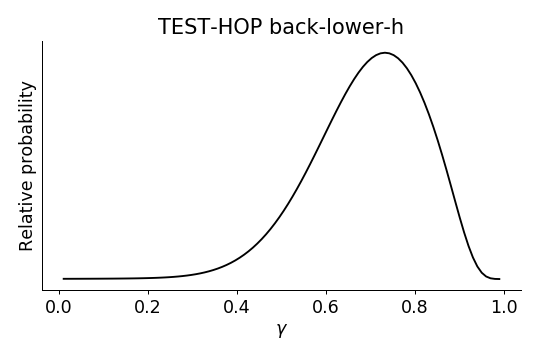

[0.69389236]


<IPython.core.display.Javascript object>


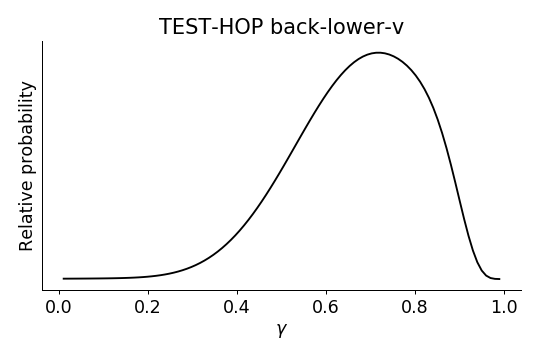

[0.67080866]


In [21]:
%matplotlib notebook

pguessogam("back-lower", "h")

pguessogam("back-lower", "v")

<IPython.core.display.Javascript object>


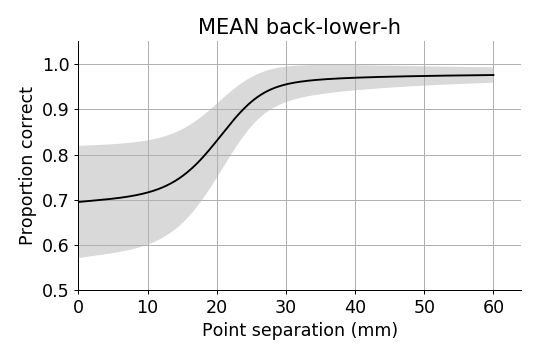

<IPython.core.display.Javascript object>


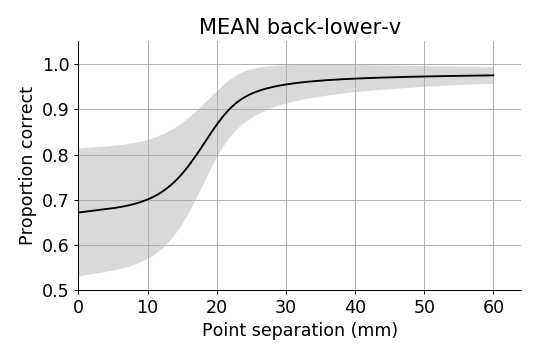

In [16]:
%matplotlib notebook

spline_h = propcorosep("back-lower", "h", 0, True, True)   #propcorosep(body site, hor or ver, hor line at value,  
                                                    #smoothing, interpolate to zero dist)

spline_h = propcorosep("back-lower", "v", 0, True, True)

<IPython.core.display.Javascript object>


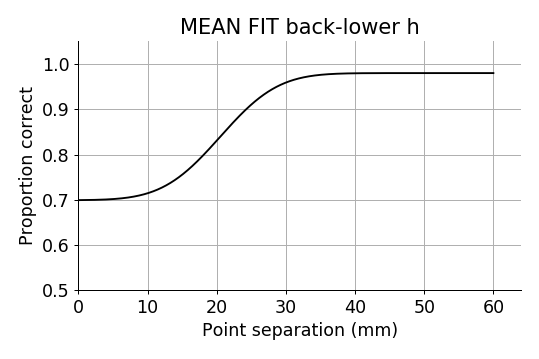

<IPython.core.display.Javascript object>


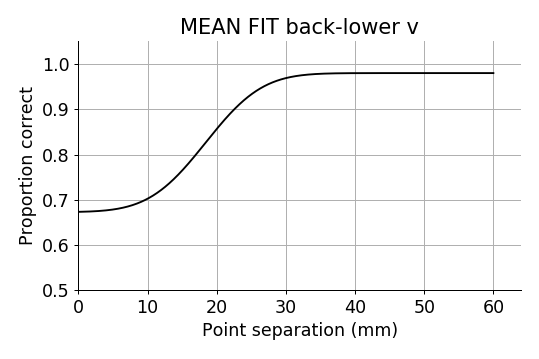

In [17]:
weibullfit('back-lower', 'h')

weibullfit('back-lower', 'v')

<IPython.core.display.Javascript object>


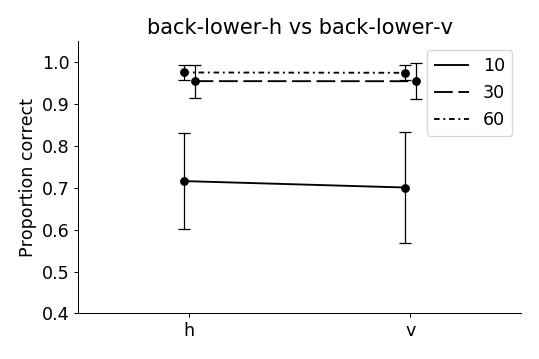

In [18]:
BS1 = 'back-lower'
BS2 = 'back-lower'

HV1 = "h"
HV2 = "v"

DOP = "d"
VALUES = [10, 30, 60]

#DOP = "p"
#VALUES = [0.6, 0.7, 0.8, 0.9]

thrshcompare(BS1, HV1, BS2, HV2, DOP, VALUES)

<IPython.core.display.Javascript object>


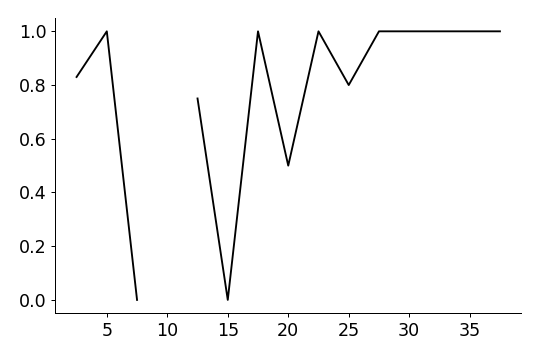

C:\Users\mvomstein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mvomstein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


       0     1     2     3
0    2.5   5.0   6.0  0.83
1    5.0   1.0   1.0  1.00
2    7.5   0.0   1.0  0.00
3   10.0   0.0   0.0   NaN
4   12.5   3.0   4.0  0.75
5   15.0   0.0   1.0  0.00
6   17.5   1.0   1.0  1.00
7   20.0   1.0   2.0  0.50
8   22.5   6.0   6.0  1.00
9   25.0   4.0   5.0  0.80
10  27.5  10.0  10.0  1.00
11  30.0   5.0   5.0  1.00
12  32.5   5.0   5.0  1.00
13  35.0   2.0   2.0  1.00
14  37.5   1.0   1.0  1.00
15  40.0   0.0   0.0   NaN
16  42.5   0.0   0.0   NaN
17  45.0   0.0   0.0   NaN
18  47.5   0.0   0.0   NaN
19  50.0   0.0   0.0   NaN
20  52.5   0.0   0.0   NaN
21  55.0   0.0   0.0   NaN
22  57.5   0.0   0.0   NaN
23  60.0   0.0   0.0   NaN


<IPython.core.display.Javascript object>


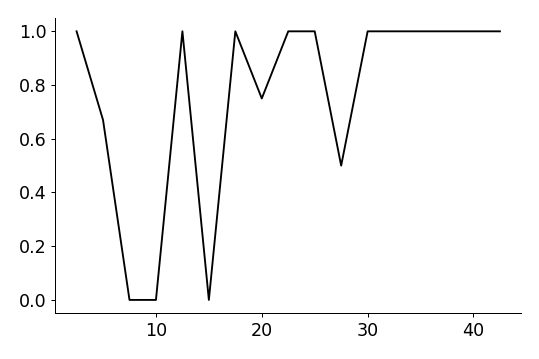

       0     1     2     3
0    2.5   4.0   4.0  1.00
1    5.0   2.0   3.0  0.67
2    7.5   0.0   1.0  0.00
3   10.0   0.0   1.0  0.00
4   12.5   1.0   1.0  1.00
5   15.0   0.0   1.0  0.00
6   17.5   1.0   1.0  1.00
7   20.0   3.0   4.0  0.75
8   22.5   7.0   7.0  1.00
9   25.0  14.0  14.0  1.00
10  27.5   1.0   2.0  0.50
11  30.0   2.0   2.0  1.00
12  32.5   1.0   1.0  1.00
13  35.0   2.0   2.0  1.00
14  37.5   2.0   2.0  1.00
15  40.0   2.0   2.0  1.00
16  42.5   2.0   2.0  1.00
17  45.0   0.0   0.0   NaN
18  47.5   0.0   0.0   NaN
19  50.0   0.0   0.0   NaN
20  52.5   0.0   0.0   NaN
21  55.0   0.0   0.0   NaN
22  57.5   0.0   0.0   NaN
23  60.0   0.0   0.0   NaN


C:\Users\mvomstein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mvomstein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


In [19]:
propcortrue('back-lower', 'h')

propcortrue('back-lower', 'v')